# Machine Learning Projekt - Gruppe 9
## Projekt: _Electric Motor Temperature Estimation_
### SS2025

Gruppenmitglieder: André Korten, Fynn Buhl, Kilian Feil, Lukas Quast, Nic Tusch, Tobias Weismantel
____

## Aufgabenstellung:

Aufgabe des Projekts ist es, auf Grundlage des vorliegenden Datensatzes die Temperatur des Permanentmagneten eines datas vorherzusagen.
Zur Umsetzung dieser Regressionsaufgabe werden zwei vorgegebene Verfahren eingesetzt: Random Forest sowie ANN. Zusätzlich wird ein drittes, selbst gewähltes Verfahren zur Modellierung und zum Vergleich herangezogen.




&nbsp;

# TODO
* Code kommentare vereinheitlichen
* jeden Block erklären, Was, wie warum 
* Markdowns einheitlich ausformuliernen


### 1. Frame the Problem and Look at the Big Picture
1. Zielsetzung:
Aus den Messwerten von Spannung U und Strom I der jeweiligen d- bzw. q-Achse die Temperatur des Permanent-Magneten vorherzusagen. Um ggf. zu hohe Temperatruren vor der Schadensentstehung zu erkennen.

__Business Objektive???__

2. Leistungsbewertung (Performance Measuremant):
Root Mean Square Error UND MAE, weil es der Standard für Regressionprobleme ist und nur von wenigen Ausreißern in den Daten ausgegangen wird. und A typical performance measure for regression problems is the **Root Mean Square Error (RMSE)**. It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

__Zielwert/Minimierung???__


3. Bisheriger Lösungsansatz:
Aktuell werden die Temperaturen in einem Versuchstand über Thermokoppler gemessen. Vermutlich reagiert ein regelbasiter Algorithmus nachgelagert auf Temperaturänderungen und drosselt die Leistung ggf.


4. Annahmen:
* supervised learning, da gelabelte Trainingsdaten vorliegen
* offline, batch learning, da alle Daten in den Speicher passen und kein kontinuirlicher Datenstrom erwartet wird
* multiple regression task, da mehrer Feature zur Vorhersage verwendet werden
* univariate regression, da nur ein einziger Wert vorhergesagt wird
* Motor ist immer heil geblieben
* nur numerische Daten



    

In [3]:

# import required packages for the whole project
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

### 2. Get the Data

**Kontext**

Der Datensatz umfasst verschiedene Sensordaten, die von einem Permanentmagnet-Synchronmotor (PMSM) auf einem Prüfstand gesammelt wurden. Bei dem PMSM handelt es sich um den Prototyp eines deutschen OEMs. Die Prüfstandsmessungen wurden von der Abteilung LEA der Universität Paderborn durchgeführt.


**Inhalt**

Alle Aufzeichnungen werden mit 2 Hz abgetastet. Der Datensatz besteht aus mehreren Messsitzungen, die durch die Spalte „profile_id“ voneinander unterschieden werden können. Eine Messsitzung kann zwischen einer und sechs Stunden lang sein.

Der Motor wird durch von Hand entworfene Fahrzyklen erregt, die eine Referenzmotordrehzahl und ein Referenzdrehmoment vorgeben.
Die Ströme in d/q-Koordinaten (Spalten „i_d“ und i_q„) und die Spannungen in d/q-Koordinaten (Spalten ‚u_d‘ und “u_q") sind das Ergebnis einer Standardregelstrategie, die versucht, der Solldrehzahl und dem Solldrehmoment zu folgen.
Die Spalten „motor_speed“ und „torque“ sind die resultierenden Größen, die durch diese Strategie erreicht werden, abgeleitet von den eingestellten Strömen und Spannungen.

Die meisten Fahrzyklen stellen Zufallsbewegungen in der Drehzahl-Drehmoment-Ebene dar, um die realen Fahrzyklen genauer zu imitieren, als dies bei konstanter Erregung und Hoch- und Herunterfahren der Fall wäre.


Quelle: _https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature_


In [4]:
# Define the path where the data file is stored
DATA_PATH = "./"
CSV_FILE = "measures_v2.csv"

# Function to load motor data from a CSV file
def load_motor_data(data_path=DATA_PATH, filename=CSV_FILE):
    csv_path = os.path.join(data_path, filename) #CSV file has a header row -> Default: Assumes that the first row is the header
    return pd.read_csv(csv_path)

# Load the motor dataset using the defined function
data = load_motor_data(DATA_PATH, CSV_FILE)

# Display information about the loaded DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


~1,3 Mio Einträge, keine leeren Werte, nur zahlen (float / integer) --> no fill of missing & no enconding

In [100]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


das sagt uns ....


In [101]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


das sagt uns....
skalieren

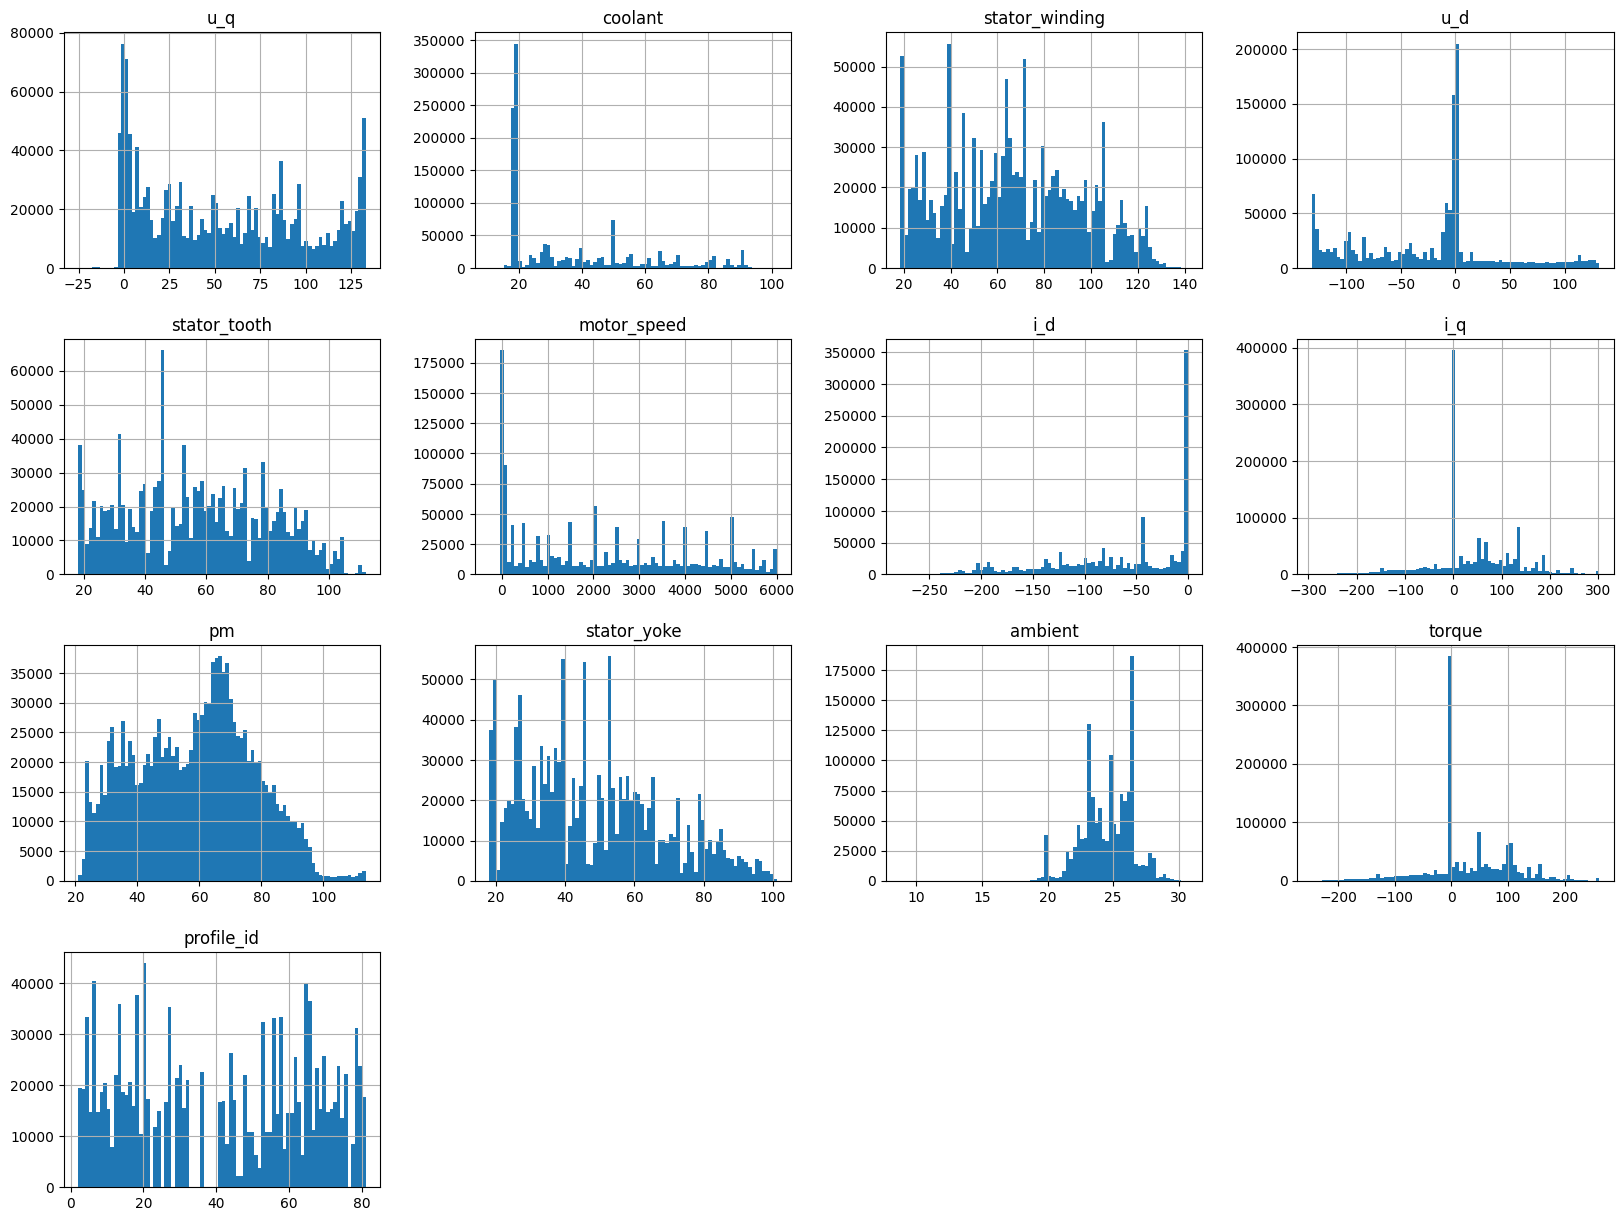

In [8]:

data.hist(bins=80, figsize=(20,15)) 
plt.show()

komische striche, ggf. null ausschließen - motor aus

Größenordnung der Einheiten passen!

allen histogrammen wirken normalverteilt

nicht alle Profi_ids belegt

count    1.330816e+06
mean     4.079306e+01
std      2.504549e+01
min      2.000000e+00
25%      1.700000e+01
50%      4.300000e+01
75%      6.500000e+01
max      8.100000e+01
Name: profile_id, dtype: float64


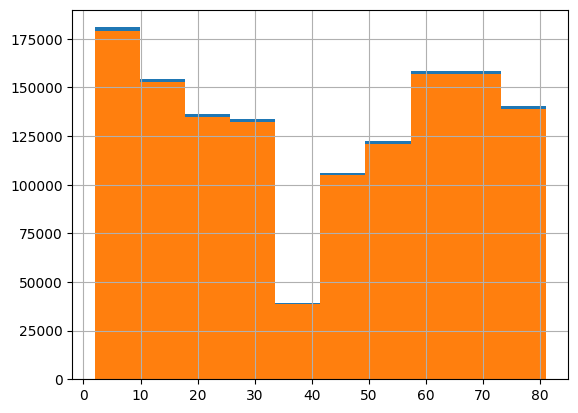

In [9]:
# sample a stratified test set from all sessions (multiple measurements can be distinguished from each other by column profile_id)
print(data["profile_id"].describe())


#Testsetsize = 1%, due to more then 100000 Datapoints
split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
for train_index, test_index in split.split(data, data["profile_id"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]


#Verify that the stratified test set (orange) preserves the same distribution shape as the full dataset (blue), 
#but with ~99% of the sample size (i.e., lower bars with identical relative frequencies).   
data["profile_id"].hist()    
strat_train_set["profile_id"].hist()
plt.show()

### 3. Explore the Data

1. Create a copy of the training set for exploration (sample it down to a manageable size if necessary).
* data = df.copy()
2. (Create a Jupyter Notebook for your data exploration.)
3. Study each attribute and its characteristics
    - name
    - type
    - % of missing values
    - noisiness
    - usefulness for task
    - type of distribution
    - ...
4. Identify the target attribute (supervised learning).
5. Visualize the data.
6. Study correlations between attributes.
7. Identify the promising transformations you may want to apply.
8. Document the results of your exploratory data analysis.

In [10]:
# copy of the training set
motor = strat_train_set.copy()

Zielattribut: pm - permanetmagnet temperatur

<Axes: xlabel='pm', ylabel='Count'>

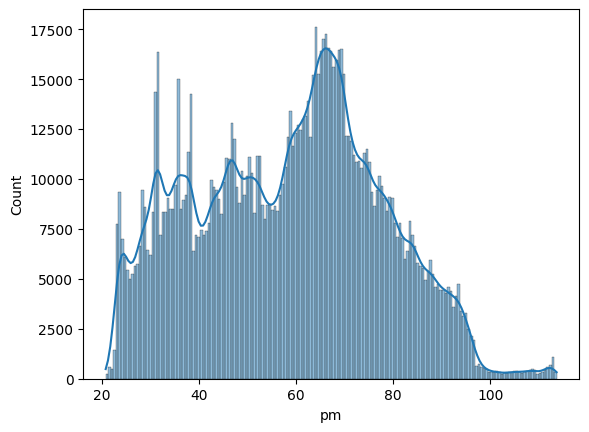

In [11]:
#Shows distributions, outliers, skewness → very helpful for target variable (pm).
sns.histplot(motor['pm'], kde=True)

In [12]:
#correlation matrix
corr_matrix = motor.corr()

#look at how much each attribute correlates with the pm temp:
corr_matrix["pm"].sort_values(ascending=False)

pm                1.000000
stator_tooth      0.832061
stator_winding    0.795862
stator_yoke       0.756669
ambient           0.513751
coolant           0.467147
motor_speed       0.459009
profile_id        0.386254
u_q               0.122437
torque           -0.117180
i_q              -0.142466
u_d              -0.172018
i_d              -0.427784
Name: pm, dtype: float64

hohe korrelation mit anderen temp., motor_speed und i_d. Profil_id nicht sinnvoll

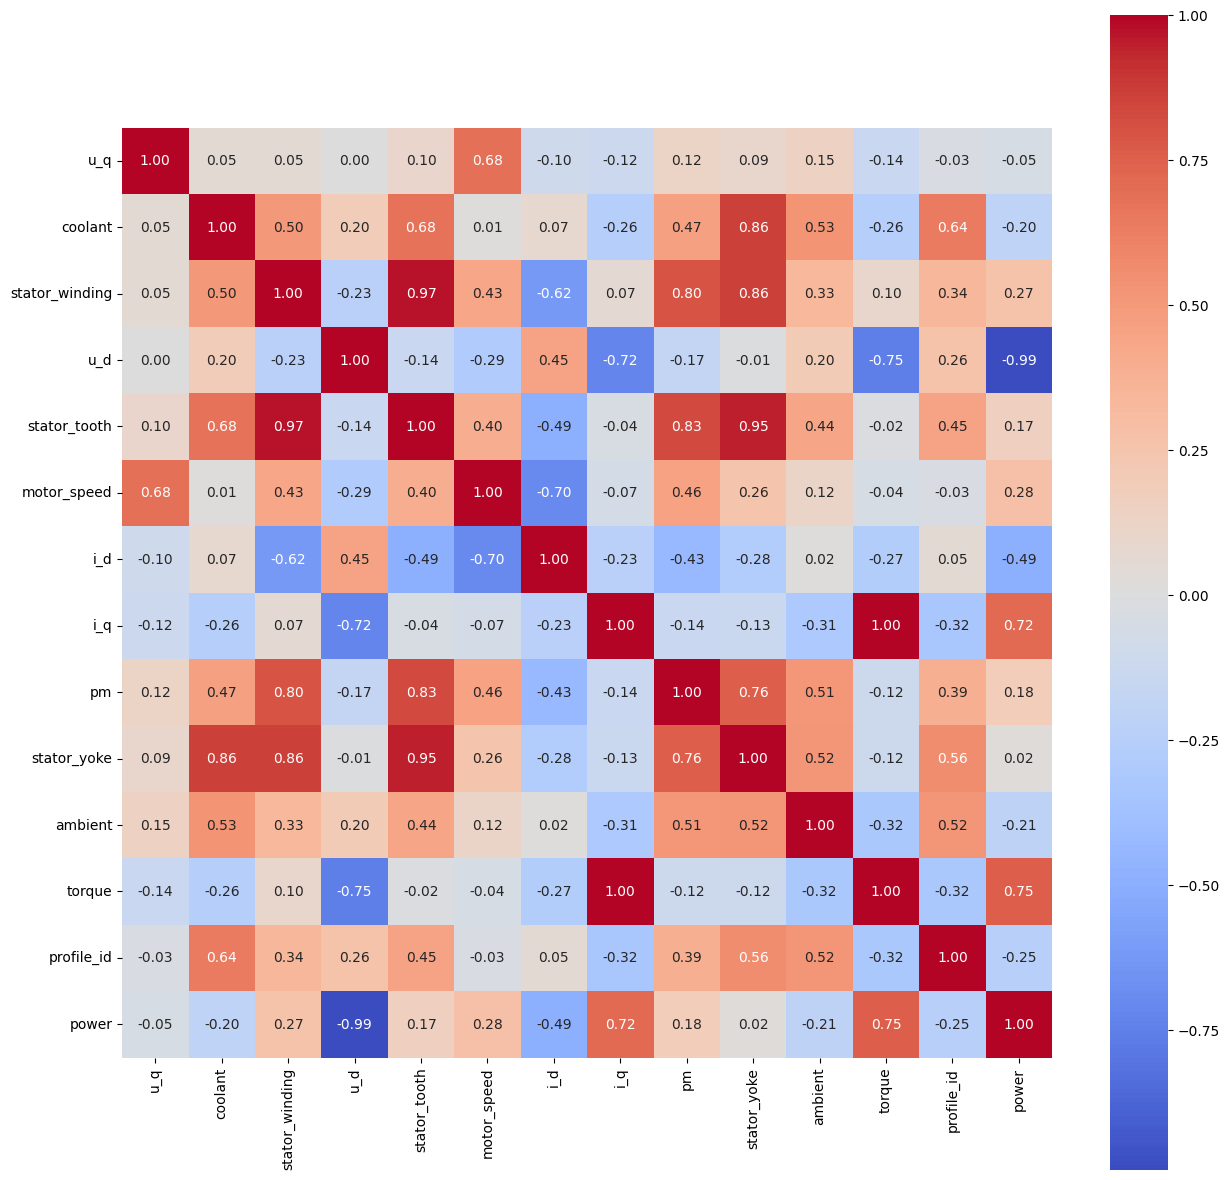

In [ ]:
#corr as heat map

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()

In [20]:
corr_matrix["motor_speed"].sort_values(ascending=False)

motor_speed       1.000000
u_q               0.683570
pm                0.459009
stator_winding    0.432052
stator_tooth      0.398458
power             0.281237
stator_yoke       0.255820
ambient           0.118233
coolant           0.011902
profile_id       -0.028579
torque           -0.043957
i_q              -0.068939
u_d              -0.288434
i_d              -0.700617
Name: motor_speed, dtype: float64

uq und id hoch korrelierent zu speed

In [13]:
#attribute combination: Power
motor["power"] = motor["u_d"] * motor["i_d"] + motor["u_q"] * motor["i_q"]
corr_matrix = motor.corr()
corr_matrix["power"].sort_values(ascending=False)

power             1.000000
torque            0.754997
i_q               0.717291
motor_speed       0.281237
stator_winding    0.267866
pm                0.184473
stator_tooth      0.165199
stator_yoke       0.020797
u_q              -0.049955
coolant          -0.198902
ambient          -0.209774
profile_id       -0.252816
i_d              -0.490677
u_d              -0.992326
Name: power, dtype: float64

Test die Leistung noch als Korrelation zu pm nicht sinnvoll; nur 0,18
Torque korreliert kaum mit pm

Aktuell keinen neuen Werte eingefügt!

In [14]:
#attribute combination: current_magnitude
motor["current_magnitude"] = np.sqrt(motor["i_d"]**2 + motor["i_q"]**2)
corr_matrix = motor.corr()
corr_matrix["current_magnitude"].sort_values(ascending=False)

current_magnitude    1.000000
stator_winding       0.571619
stator_tooth         0.417894
torque               0.400765
power                0.399350
motor_speed          0.382430
i_q                  0.376683
pm                   0.251773
stator_yoke          0.232263
u_q                 -0.014745
ambient             -0.055007
profile_id          -0.082974
coolant             -0.092726
u_d                 -0.357179
i_d                 -0.845771
Name: current_magnitude, dtype: float64

current_magnitude (i) corr mit temp. (stator_winding & tooth) -> einfluss auf pm

### 4. Prepare the Data

1. Write functions for all data transformations you apply.
2. Clean the data.
    - remove outliers
    - fill in missing values
3. Select important features (drop attributes that provide no useful information for the task).
4. Use feature engineering.
    - decompose categorical features
    - add promising transformations for features
    - aggregate features into promissing new features
5. Use feature scaling (standardize or normalize features).

In [15]:
# Labels vorbereiten
motor_pm_labels = strat_train_set["pm"].copy()
motor = strat_train_set.drop("pm", axis=1) # drop pm for training set

In [16]:
# Daten bereinigen von unwichtigen Information
motor = motor.drop("profile_id", axis=1)
#motor = motor.drop("coolant", axis=1) 
#motor = motor.drop("stator_winding", axis=1)
#motor = motor.drop("stator_tooth", axis=1)
#motor = motor.drop("stator_yoke", axis=1)
#motor = motor.drop("ambient", axis=1)

motor.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque
486400,73.499413,18.620235,23.520418,-0.246484,23.678951,1499.983521,-2.000962,1.097150,21.984486,23.888302,-2.366589e-02
724527,70.820196,28.859377,79.982515,-3.026034,65.189878,1495.647860,-2.659218,4.360475,50.937160,26.384446,2.173315e+00
641872,-0.174199,79.659683,70.842393,3.290139,70.861331,0.002076,-2.000971,1.097257,72.114404,26.602693,-1.603729e-211
108384,4.176036,18.453747,19.713879,1.483652,19.082251,99.974022,-1.999888,1.095639,18.994600,21.466301,2.330701e-01
882919,107.053965,86.091312,96.735314,-76.085422,91.334451,3499.971770,-74.765850,61.168734,86.857632,25.000909,5.000000e+01


No Missing values, deswegen keine daten auffüllen

numerical onyl, deswegen keinen encoder

In [19]:
#custom transformer

class CurrentMagnitudeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_current_magnitude=True):
        self.add_current_magnitude = add_current_magnitude

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not self.add_current_magnitude:
            return X

        # DataFrame: Berechne neue Spalte und hänge sie an
        current_magnitude = np.sqrt(X["i_d"]**2 + X["i_q"]**2)
        return X.assign(current_magnitude=current_magnitude)

# Instantiate transformer with feature addition enabled
attr_adder = CurrentMagnitudeAdder(add_current_magnitude=True)
# Apply to  dataset
motor_extra_attribs = attr_adder.transform(motor)

# print the first rows of the housing_extra_attribs DF
motor_extra_attribs.head()


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque,current_magnitude
486400,73.499413,18.620235,23.520418,-0.246484,23.678951,1499.983521,-2.000962,1.097150,21.984486,23.888302,-2.366589e-02,2.282013
724527,70.820196,28.859377,79.982515,-3.026034,65.189878,1495.647860,-2.659218,4.360475,50.937160,26.384446,2.173315e+00,5.107365
641872,-0.174199,79.659683,70.842393,3.290139,70.861331,0.002076,-2.000971,1.097257,72.114404,26.602693,-1.603729e-211,2.282073
108384,4.176036,18.453747,19.713879,1.483652,19.082251,99.974022,-1.999888,1.095639,18.994600,21.466301,2.330701e-01,2.280346
882919,107.053965,86.091312,96.735314,-76.085422,91.334451,3499.971770,-74.765850,61.168734,86.857632,25.000909,5.000000e+01,96.599929


da nur numericla values / gleiche datentypen, pipeline geeeignet statt columtransformert

In [20]:
pipeline = Pipeline([
        ('attribs_adder', CurrentMagnitudeAdder()),
        ('minmax_scaler', MinMaxScaler()),
    ])

motor_prepared = pipeline.fit_transform(motor)
motor_prepared

array([[0.62396032, 0.08789783, 0.04019157, ..., 0.68875163, 0.4856284 ,
        0.00631225],
       [0.60703838, 0.20044708, 0.50006651, ..., 0.80257113, 0.48995767,
        0.01412755],
       [0.15863741, 0.75884708, 0.42562164, ..., 0.81252277, 0.48567504,
        0.00631241],
       ...,
       [0.70788929, 0.59810624, 0.70212916, ..., 0.79471442, 0.57926196,
        0.39653993],
       [0.32832825, 0.22058807, 0.55632123, ..., 0.80256344, 0.26803635,
        0.60589899],
       [0.16286624, 0.39499134, 0.24177286, ..., 0.80257297, 0.48567504,
        0.00631241]], shape=(1317507, 12))

MinMax benutzt weil für ANN sinnvoll und für Random Forrest egal

imputor und attribus_adder weggelassen weil keine Werte hinzugefügt

### 5. Select and Train your Models

1. Learn the basics about the models you've been assigned.
2. Select a 3rd model on your own. Use criteria for your selection.
3. Make a plan for training and evaluation of the models.
4. Build your models (select meaningful values for the model parameters).
5. Train your models with the training set.
6. Measure and compare the performance of your models (use N-fold cross-validation).
7. Analyze the most significant parameters for each model.
8. Analyze the types of errors the models make.

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(motor_prepared, motor_pm_labels)

LinearRegression()

In [23]:
# let's try the full preprocessing pipeline on a few training instances
some_data = motor.iloc[:5]
some_labels = motor_pm_labels.iloc[:5]
some_data_prepared = pipeline.transform(some_data)

print("Predictions   :", np.round(lin_reg.predict(some_data_prepared),1))
print("Actual Labels :", list(some_labels))

Predictions   : [36.6 68.3 67.9 29.8 74.8]
Actual Labels : [31.186717987060547, 60.64904849267637, 63.75366416399909, 23.9774112701416, 76.98651792173555]


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

motor_predictions = lin_reg.predict(motor_prepared)

lin_mse = mean_squared_error(motor_pm_labels, motor_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(motor_pm_labels, motor_predictions)

print("RMSE: %.2f, MAE: %.2f" % (lin_rmse, lin_mae))

RMSE: 7.24, MAE: 5.43


In [25]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, motor_prepared, motor_pm_labels,
                         scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())
     
display_scores(lin_rmse_scores)

Scores: [7.20622628 7.23009467 7.22414824 7.22378932 7.25559551 7.21558414
 7.23956813 7.28734184 7.2379743  7.24613826]
Mean: 7.236646068608707
Standard deviation: 0.02182413294116575


### 6. Fine-Tune your Models

1. Fine-tune the hyperparameters using cross-validation.
    - treat your data transformation choices as hyperparameters, especially when you are not sure about them. (e.g. if you are not sure whether to replace missing values with zeros or with the median value, or to just drop the rows.)
    - use grid search and random search $\to$ compare and evaluate the results.
2. Compare the results of all three models after the fine-tuning process to determine the best hyperparameters.
3. Select a final model and measure its performance on the test set to estimate the generalization error.
    - dont tweak your model after measuring the generalization error: you would just start overfitting the test set.
4. Document the results of the examined models. Pay particular attention to the final model.

### 7. Present Your Solution

1. Document what you have done.
    - write a summary of the results in a new, final section
    - explain why your solution achieves the task objective
2. Create a nice presentation.
    - make sure to highlight the big picture first
    - make sure you explain the assigned model in detail to your fellow students
    - dont forget to present interesting points you noticed along the way
    - list your assumptions and your systems limitations
    - ensure your key findings are communicated